In [9]:
#预处理，读取图片
# perform complete 3D reconstruction from 11 images
import bundle_adjustment
import feature_extraction
import feature_matching
import initial_recon
import pnp_recon
import cv2
import numpy as np
image_names = ["0000.png","0001.png","0002.png","0003.png","0004.png","0005.png","0006.png","0007.png","0008.png","0009.png","0010.png"]
images = []
for image_name in image_names:
    image_path = r"images\images\\"+image_name
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype("float32")
    images.append(gray_image)

#特征提取
key_des = []
for i in range(11):
    keypoints,descriptors = feature_extraction.extract_features(images[i])
    key_des.append((keypoints,descriptors))

matching_list= []
for i in range(10):
    keypoints1,descriptors1 = key_des[i%2]
    keypoints2,descriptors2 = key_des[i+1] 
    matching_list.append(list(feature_matching.match_features(keypoints1,descriptors1,keypoints2,descriptors2)))

with open("camera_intrinsic.txt",'r') as File:
    lines = File.readlines()
camera_intrinsic = []
for line in lines:
    row = [float(x) for x in line.split()]
    camera_intrinsic.append(row)

camera_intrinsic = np.array(camera_intrinsic)

In [10]:
import open3d as o3d
def show3dpts(pts3dall):
    points=o3d.utility.Vector3dVector(pts3dall)
    pcd=o3d.geometry.PointCloud()
    pcd.points = points
   
    vis = o3d.visualization.Visualizer()
    vis.create_window()	
    render_option: o3d.visualization.RenderOption = vis.get_render_option()	
    render_option.background_color = np.array([0, 0, 0])	
    render_option.point_size = 2.0	
    vis.add_geometry(pcd)	
    vis.run()
    vis.destroy_window()

In [11]:
from copy import deepcopy


cur_dst_pts = matching_list[0][1]
cur_src_pts = matching_list[0][2]
R,t = initial_recon.initial_recon_func(cur_dst_pts,cur_src_pts,camera_intrinsic)#在这里我把src提到了前面作为points1，也就是0001.png，最终求出了使得x1 = Rx2+t的结果
cur_T1 = np.hstack((camera_intrinsic,np.zeros((camera_intrinsic.shape[0],1))))
cur_T2 = np.hstack((np.dot(camera_intrinsic,R),np.dot(camera_intrinsic,t)))
cur_points_4d_homogeneous = cv2.triangulatePoints(cur_T1,cur_T2,cur_dst_pts,cur_src_pts)
cur_points_3d = cv2.convertPointsFromHomogeneous(cur_points_4d_homogeneous.T)
dist_coeffs = np.zeros((5,1))
success, cur_R_pnp, cur_t_pnp = cv2.solvePnP(cur_points_3d, cur_src_pts, camera_intrinsic,dist_coeffs,flags=cv2.SOLVEPNP_EPNP)
cur_R_pnp,_ = cv2.Rodrigues(cur_R_pnp)

copy_cur_R_pnp, copy_cur_t_pnp,copy_cur_points_3d,copy_cur_src_pts,copy_cur_dst_pts = deepcopy(cur_R_pnp),deepcopy(cur_t_pnp),deepcopy(cur_points_3d),deepcopy(cur_src_pts),deepcopy(cur_dst_pts)
R,t,cur_R_pnp, cur_t_pnp
#R、t区别很小


(array([[ 0.98849803, -0.02072042, -0.14980759],
        [ 0.02319307,  0.99962179,  0.01477705],
        [ 0.14944474, -0.01808158,  0.98860474]]),
 array([[ 0.9973868 ],
        [ 0.03367535],
        [-0.0639182 ]]),
 array([[ 0.98855912, -0.02054217, -0.14942853],
        [ 0.02297665,  0.99962963,  0.01458363],
        [ 0.14907361, -0.01785014,  0.98866497]]),
 array([[ 0.99531662],
        [ 0.03532443],
        [-0.06633271]]))

In [12]:

cur_R_pnp, cur_t_pnp,cur_points_3d,cur_src_pts,cur_dst_pts = copy_cur_R_pnp, copy_cur_t_pnp,copy_cur_points_3d,copy_cur_src_pts,copy_cur_dst_pts
list0 = []
list0.append(np.vstack((np.hstack((np.eye(3),np.zeros((3,1)))),np.array([0,0,0,1]))))#考虑第一个相机
points_3d_all = []
points_3d_all.append(cur_points_3d)#这里以及之后是不考虑第一个相机的
src_pts_all = []
src_pts_all.append(cur_src_pts)
model_R_pnp,model_t_pnp,model_points_3d,model_src_pts,model_dst_pts = [cur_R_pnp], [cur_t_pnp],[cur_points_3d],[cur_src_pts],[cur_dst_pts]
model_dst_R = [np.eye(3),cur_R_pnp]
model_dst_t = [np.zeros((3,1)),cur_t_pnp]
#pnp最终结果
for i in range(1,2):
    M = np.hstack((cur_R_pnp,cur_t_pnp))
    M = np.vstack((M,np.array([0,0,0,1])))

    list0.append(M)

    new_dst_pts = matching_list[i][1]
    new_src_pts = matching_list[i][2]
    index1,index2 = pnp_recon.find_matching_rows(cur_src_pts,new_dst_pts)

    dist_coeffs = np.zeros((5,1))
    success, new_R_pnp, new_t_pnp = cv2.solvePnP(cur_points_3d[index1], new_src_pts[index2], camera_intrinsic,dist_coeffs,flags=cv2.SOLVEPNP_EPNP)
    
    new_R_pnp,_ = cv2.Rodrigues(new_R_pnp)
    cur_T1 = np.hstack((np.dot(camera_intrinsic,cur_R_pnp),np.dot(camera_intrinsic,cur_t_pnp)))
    cur_T2 = np.hstack((np.dot(camera_intrinsic,new_R_pnp),np.dot(camera_intrinsic,new_t_pnp)))

    cur_points_4d_homogeneous = cv2.triangulatePoints(cur_T1,cur_T2,new_dst_pts,new_src_pts)
    cur_points_3d = cv2.convertPointsFromHomogeneous(cur_points_4d_homogeneous.T)

    points_3d_all.append(cur_points_3d[index2])

    src_pts_all.append(new_src_pts[index2])

    cur_R_pnp,cur_t_pnp = new_R_pnp, new_t_pnp
    cur_dst_pts,cur_src_pts = new_dst_pts,new_src_pts

model_R_pnp.append(cur_R_pnp)
model_t_pnp.append(cur_t_pnp)
model_points_3d.append(cur_points_3d)
model_src_pts.append(cur_src_pts)
model_dst_pts.append(cur_dst_pts)

for i in range(2,10):
    M = np.hstack((cur_R_pnp,cur_t_pnp))
    M = np.vstack((M,np.array([0,0,0,1])))

    list0.append(M)

    cur_R_pnp, cur_t_pnp,cur_points_3d,cur_src_pts,cur_dst_pts = model_R_pnp[i%2],model_t_pnp[i%2],model_points_3d[i%2],model_src_pts[i%2],model_dst_pts[i%2]
    new_dst_pts = matching_list[i][1]
    new_src_pts = matching_list[i][2]
    index1,index2 = pnp_recon.find_matching_rows(cur_dst_pts,new_dst_pts)

    dist_coeffs = np.zeros((5,1))
    success, new_R_pnp, new_t_pnp = cv2.solvePnP(cur_points_3d[index1], new_src_pts[index2], camera_intrinsic,dist_coeffs,flags=cv2.SOLVEPNP_EPNP)
    
    new_R_pnp,_ = cv2.Rodrigues(new_R_pnp)
    cur_T1 = np.hstack((np.dot(camera_intrinsic,model_dst_R[i%2]),np.dot(camera_intrinsic,model_dst_t[i%2])))
    cur_T2 = np.hstack((np.dot(camera_intrinsic,new_R_pnp),np.dot(camera_intrinsic,new_t_pnp)))

    cur_points_4d_homogeneous = cv2.triangulatePoints(cur_T1,cur_T2,new_dst_pts,new_src_pts)
    cur_points_3d = cv2.convertPointsFromHomogeneous(cur_points_4d_homogeneous.T)

    points_3d_all.append(cur_points_3d)

    src_pts_all.append(new_src_pts)

    cur_R_pnp,cur_t_pnp = new_R_pnp, new_t_pnp
    cur_dst_pts,cur_src_pts = new_dst_pts,new_src_pts

M = np.hstack((cur_R_pnp,cur_t_pnp))
M = np.vstack((M,np.array([0,0,0,1])))

list0.append(M)

with open ("pnp.txt","w") as file:
    for i in list0:
        np.savetxt(file, i.reshape(1,-1))  # 写入第一个矩阵
        file.write('\n')  # 换行

In [13]:
def delete_too_big(n):
    for i in n:
        if abs(i)>10:
            return False
    return True
listk = []
for i in points_3d_all:
    listk.extend([i.squeeze()[j] for j in range(i.shape[0])])
print(len(listk))
listk = filter(delete_too_big,listk)
listk =list(listk)
print(len(listk))
show3dpts(listk)

3035
3022


In [14]:
for i in points_3d_all:
    print(len(i))

1251
781
236
453
88
154
36
14
13
9


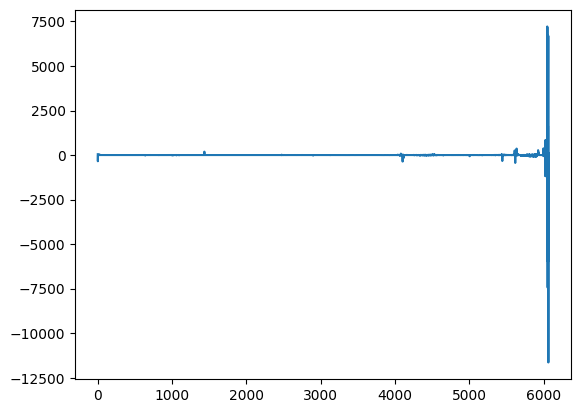

In [15]:
import numpy as np
from scipy.sparse import lil_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import trimesh
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    cmat = np.matrix([[2759.48,0,1520.69],[0,2764.16,1006.81],[0,0,1]])
    points_proj= np.array(points_proj @ cmat.T)
    
    for i in range(points_proj.shape[0]):
        points_proj[i][0] /= points_proj[i][2]
        points_proj[i][1] /= points_proj[i][2]
    return points_proj[:,:2]


# def fun_1(params, n_cameras, n_points, camera_indices, point_indices, fun_points_2d,maxmin = 2000):
#     def delete_too_big_2(n):
#         if n<0:
#             return False
#         return True
#     """Compute residuals.
    
#     `params` contains camera parameters and 3-D coordinates.
#     """
#     camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
#     fun_points_3d = params[n_cameras * 6:].reshape((n_points, 3))
#     points_proj = project(fun_points_3d[point_indices], camera_params[camera_indices])
#     respp = (points_proj - fun_points_2d.squeeze())
#     index = []
#     for i in range(len(respp)):
#         for j in range(2):
#             if abs(respp[i][j])>maxmin:
#                 index.append(i)
#                 break

#     up_point_indices = point_indices
#     up_point_indices[index] = -1
#     up_point_indices = filter(delete_too_big_2,up_point_indices)
#     up_point_indices = np.array(list(up_point_indices))

#     up_camera_indices = camera_indices
#     up_camera_indices[index] = -1
#     up_camera_indices = filter(delete_too_big_2,up_camera_indices)
#     up_camera_indices = np.array(list(up_camera_indices))

#     print(len(point_indices),len(up_point_indices))
#     return up_point_indices,up_camera_indices,respp.ravel()

def fun_2(params, n_cameras, n_points, camera_indices, point_indices, fun_points_2d,maxmin = 2000):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
    fun_points_3d = params[n_cameras * 6:].reshape((n_points, 3))
    points_proj = project(fun_points_3d[point_indices], camera_params[camera_indices])
    respp = (points_proj - fun_points_2d[point_indices].squeeze()).ravel()
    return respp

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 6 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(6):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 6 + point_indices * 3 + s] = 1

    return A
def get_params(list1,d3_po_all,d2_po_all):
    cameras = []
    parm_points_3d = []
    parm_points_2d = []
    point_indices = []
    camera_indices = []
    cnt = 0
    for i in range(1,len(list1)):
        rot_vec = np.zeros((3,))
        cv2.Rodrigues(list1[i][:3,:3], rot_vec)
        x_cam = np.zeros((6))
        x_cam[:3] = rot_vec
        x_cam[3:] = list1[i][:3,3]
        cameras.append(x_cam)
    for i in range(10):
        for j in range(len(d3_po_all[i])):
            camera_indices.append(i)
            parm_points_2d.append(d2_po_all[i][j])
            parm_points_3d.append(d3_po_all[i][j])
            point_indices.append(cnt)
            cnt += 1
    return np.array(cameras),np.squeeze(np.array(parm_points_3d)),np.array(parm_points_2d),np.array(camera_indices),np.array(point_indices)

n_cameras, parm_points_3d,parm_points_2d ,camera_indices, point_indices = get_params(list0,points_3d_all,src_pts_all)
all_n_points = len(camera_indices)
x0 = np.hstack((n_cameras.ravel(),parm_points_3d.ravel()))
# point_indices,camera_indices,f0 = fun_1(x0,10,all_n_points,camera_indices,point_indices,parm_points_2d)
# plt.plot(f0)
# plt.show()
f0 = fun_2(x0,10,all_n_points,camera_indices,point_indices,parm_points_2d)
plt.plot(f0)
plt.show()
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 6 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(6):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 6 + point_indices * 3 + s] = 1

    return A


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.8084e+08                                    9.91e+09    
       1              2         6.7910e+07      2.13e+08       9.18e+00       1.11e+09    
       2              4         3.3124e+07      3.48e+07       1.02e+00       2.52e+08    
       3              5         1.1446e+07      2.17e+07       1.90e+00       7.78e+07    
       4              6         7.8390e+05      1.07e+07       1.40e+00       4.85e+07    
       5              7         1.2724e+04      7.71e+05       3.27e-01       5.27e+06    
       6              8         8.8134e+00      1.27e+04       4.32e-02       1.04e+05    
       7              9         7.1641e-06      8.81e+00       1.26e-03       8.38e+01    
       8             10         6.4493e-16      7.16e-06       1.14e-06       4.69e-04    
`xtol` termination condition is satisfied.
Function evaluations 10, initial cost 2.8084e+0

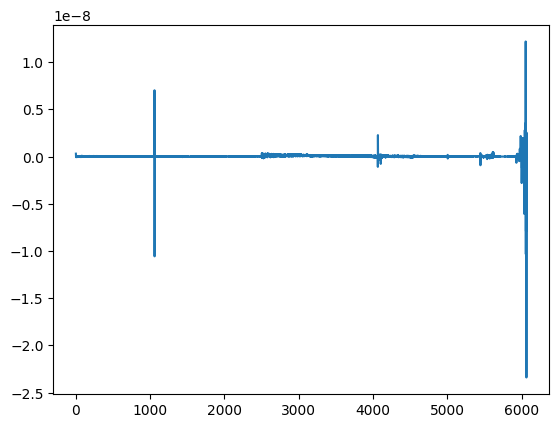

3035
3022


b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 3035\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nproperty uchar alpha\nend_header\n\x8fT\x05\xbf\x02\xd0\x11>\x0b\xc0g?\x00\x00\x00\x00\xd6/8\xc0\x17\x9f\xc7?_\xd5\xc4@\x00\x00\x00\x00(@7\xc0\xda,\x02\xc0#\xd3\xc4@\x00\x00\x00\x00\xe8!6\xc0\x8b\xd2\xb4\xbf6\x9f\xc3@\x00\x00\x00\x00\xc8\xb96\xc0\xe4\xa7\x02\xc0vI\xc5@\x00\x00\x00\x00\x19(\x86\xc0\xa1\xd6\x1a\xc0At\x13A\x00\x00\x00\x00\xc8(\x82\xc0\x14\x8c\n\xc0j\x95\x10A\x00\x00\x00\x00)B\x81\xc0R\x81\x07\xc0\x8e\x8e\x10A\x00\x00\x00\x00)B\x81\xc0R\x81\x07\xc0\x8e\x8e\x10A\x00\x00\x00\x00\x88\x91\x80\xc0\xd4\x9c\x08\xc0\xf6\xda\x10A\x00\x00\x00\x00A\xe5y\xc0Y>\x01\xc0\xae\xfc\x0eA\x00\x00\x00\x00\x96~x\xc0\xd8\xbf!\xc0\xd3\xf1\rA\x00\x00\x00\x00\xda\xe2}\xc0\xba\xe4E\xc0\xfa\xba\x12A\x00\x00\x00\x00\xc8(j\xc0\x19?\xe2?\xcf\xad\x08A\x00\x00\x00\x00$\xb1c\xc09\x8b\xe3\x

In [16]:

import time
from scipy.optimize import least_squares

list2 = []
list2.append(np.vstack((np.hstack((np.eye(3),np.zeros((3,1)))),np.array([0,0,0,1]))))#考虑第一个相机

def bundle_adjustment(camera_indices,point_indices,parm_points_2d,n_cameras = 10):
    global list2
    A = bundle_adjustment_sparsity(n_cameras, len(camera_indices), camera_indices, point_indices)

    t0 = time.time()
    res = least_squares(fun_2, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-1, method='trf',
                        args=(n_cameras, len(camera_indices), camera_indices, point_indices, parm_points_2d))
    t1 = time.time()
    print("Optimization took {0:.0f} seconds".format(t1 - t0))
    plt.plot(res.fun)
    plt.show()
    xnew = res.x
    resRvi = []#vector
    rest = []
    resp3d = []
    resR = []
    for i in range(n_cameras):
        resRvi.append(xnew[i*6:6*i+3])
        rest.append(xnew[6*i+3:6*i+6].reshape((3,1)))

    for i in range(n_cameras):
        resR.append(cv2.Rodrigues(resRvi[i])[0])   

    for i,(R_,t_) in enumerate(zip(resR,rest)):
        M = np.hstack((R_,t_))
        M = np.vstack((M,np.array([0,0,0,1])))
        list2.append(M)

    resp3d = []
    for i in range(len(camera_indices)):
        resp3d.append(xnew[6*n_cameras+3*i:6*n_cameras+3*i+3])
    return resp3d
resp3d_real = bundle_adjustment(camera_indices,point_indices,parm_points_2d,10)
print(len(resp3d_real))
resp3d = filter(delete_too_big,resp3d_real)
resp3d =list(resp3d)
print(len(resp3d))
show3dpts(resp3d)

with open ("521030910127.txt","w") as file:
    for i in list2:
        np.savetxt(file, i.reshape(1,-1))  # 写入第一个矩阵
        file.write('\n')  # 换行

point_cloud = trimesh.points.PointCloud(resp3d_real)

# 保存为PLY文件
point_cloud.export('521030910127.ply')